In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import gamma
from math import pi

## The curse of dimensionality

What does it mean for you?

Thinking in high-dimensional spaces is hard, and intuitions we build from low-dimensional spaces sometimes go wrong. Here is a list of counter-intuitive results *(Verleysen et al., 2003)*:

**1. Volume behaves oddly**

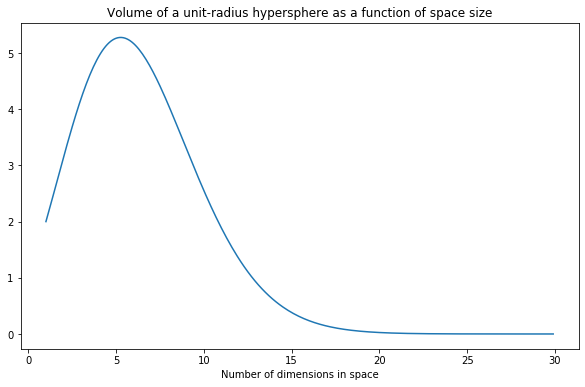

In [3]:
dimensions = np.arange(1, 30, 0.1)

unit_hyper_sphere_volume = []
for d in dimensions:
    unit_hyper_sphere_volume.append(pi**(d/2)/gamma(d/2 + 1))

fig = plt.figure(figsize=(10, 6))
plt.title('Volume of a unit-radius hypersphere as a function of space size')
plt.xlabel('Number of dimensions in space')
plt.plot(dimensions, unit_hyper_sphere_volume)

In high dimensional spaces, a unit hypersphere is almost empty

In [4]:
dimensions = np.arange(1, 30, 0.1)

radius = 1
epsilon=0.1
hyper_sphere_volume = []
smaller_hyper_sphere_volume = []

for d in dimensions:
    hyper_sphere_volume.append(pi**(d/2) * radius**d / gamma(d/2 + 1))
    smaller_hyper_sphere_volume.append(pi**(d/2) * (radius-epsilon)**d / gamma(d/2 + 1))
    
ratios = np.divide(np.array(smaller_hyper_sphere_volume), np.array(hyper_sphere_volume))

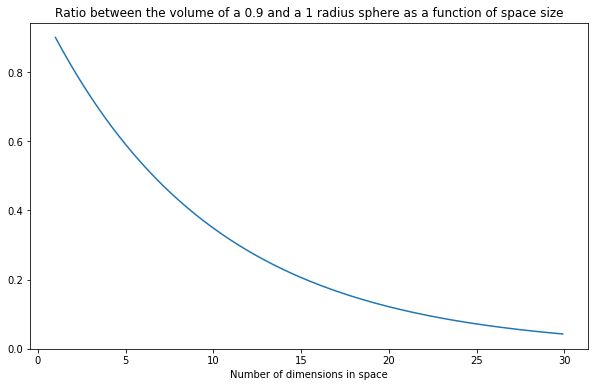

In [5]:
fig = plt.figure(figsize=(10, 6))
plt.title('Ratio between the volume of a 0.9 and a 1 radius sphere as a function of space size')
plt.xlabel('Number of dimensions in space')
plt.plot(dimensions, ratios)

In high dimensional spaces, the volume of an hyper space concentrates on its outer shell

In [6]:
dimensions = np.arange(0, 8, 0.1)

nb_points_in_unit_hypercube = []
for d in dimensions:
    nb_points_in_unit_hypercube.append(10**d)

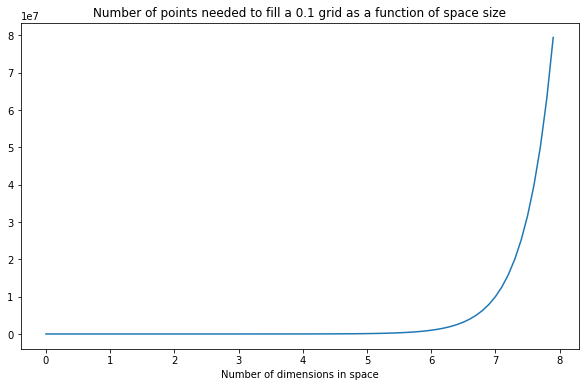

In [7]:
fig = plt.figure(figsize=(10, 6))
plt.title('Number of points needed to fill a 0.1 grid as a function of space size')
plt.xlabel('Number of dimensions in space')
plt.plot(dimensions, nb_points_in_unit_hypercube)

The higher the number of dimensions, the sparser the space

In [8]:
def distance_to_nearest_and_furthest_neighboors(point, neighboors):
    nearest = np.inf
    furthest = -np.inf
    for n in neighboors:
        dist = np.linalg.norm(n-point, 2)
        if dist < nearest:
            nearest = dist
        elif dist >= furthest:
            furthest = dist
    return nearest, furthest

dimensions = np.arange(1, 3000, 1)
nb_points = 10

distances = []
for d in dimensions:
    points = np.random.random_sample((d, nb_points))
    p0 = points[0]
    others = points[1:]
    nearest_dist, furthest_dist = distance_to_nearest_and_furthest_neighboors(p0, others)
    distances.append(furthest_dist-nearest_dist)

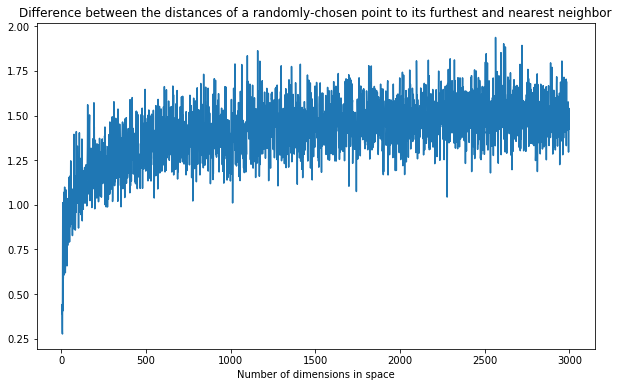

In [9]:
fig = plt.figure(figsize=(10, 6))
plt.title('Difference between the distances of a randomly-chosen point to its furthest and nearest neighbor')
plt.xlabel('Number of dimensions in space')
plt.plot(dimensions, distances)
plt.show()

There is no sense in using "classic" similarities in high dimensions.

Why does it matter?

Let's look at the objective of generating "fake" data. Why would we do that?

1. Richard Feynman: *"What I cannot create, I cannot understand"*
2. Various use of generated data:
    * Data augmentation
    * Image/Audio "super resolution"
    * Machine translation
    * Image translation
    * Imitation learning
    
How would you generate data?

One solution would be to learn the underlying probability distribution of our data, let's call it $p(X)$

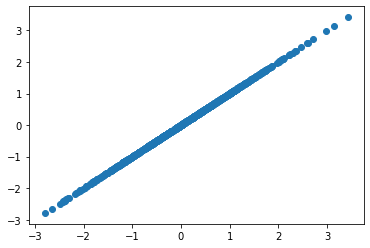

In [10]:
x = np.random.normal(size=1000)
plt.scatter(x, x)

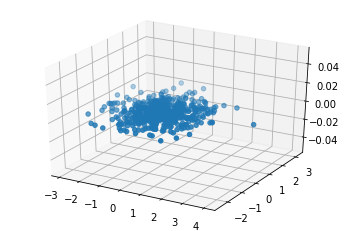

In [11]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.random.normal(size=(2,500))
ax.scatter(x[0], x[1])

We see that points are further away from each other. We cannot plot in more than 3 dimensions, but as we have seen earlier, space will become sparser as we add new dimensions. We will need a therotically-infinite amount of data (and computation power) to be able to learn $p(X)$

An idea would be to learn a representation of our data in a lower-dimensional space. A lot of possibilities exist to do that: Principal Component Analysis, Latent Dirichlet Allocation, ...

Let's look at Auto-Encoders: their goal is twofold:
1. *to create some code* of the original signal (here an image) in a lower-dimensional space
2. *to recreate the closest signal possible* to the initial signal from the lower-dimensional code


![Let's look at Auto-Encoders](img/ae.png)

(Credits: https://danijar.com/building-variational-auto-encoders-in-tensorflow/)

One of the most common objective function for auto-encoders is the reconstruction error:

\begin{equation}
\arg\,\min_{\theta, \phi} E\,\big[L(x,\,g_\phi(f_\theta(x))\big]
\end{equation}

What do you think about the Decoder part of the Auto-encoder?

It generates a high-dimensional signal from a low-dimensional representation of the signal. Looks like a generator that got rid of the issue of high-dimensional spaces!

Or did it...

A very small image would be 28\*28 = 784 dimensions (let's say we have binarized the color scale in black or white to make the problem... hum... less difficult)

To be able to reconstruct the data, we need a low-dimensional space that is not so low-dimensional (let's say 64 dimensions). 64 is far less than 784, but it is still a lot of dimensions. What do you think the big issue is for the decoder part if we consider it as a generative model?

The encoder will create code in a 64-dimensions space. If we take the MNIST data, we have 10 classes. The encoder will map the 784-dimensions input signal into some representation in 64-dimension space. If we sample some random point in this 64 dimensional space, give it to the decoder to generate an image, we will almost surely create an image displaying random noise.

Is it a lost cause then?

When you do not have enough data, or if your model is untractable, one solution might be to add some prior knowledge. Let's come back to our auto-encoder:

![Let's look at Auto-Encoders](img/ae.png)


Let's say that our encoder should map the 784-dimensions input signal into not just a 64-dimensions space but a 64-dimensions multivariate gaussian $p(Z) \sim \mathcal{N}(\mathcal{0},\,\sigma^2\,I)\,$

We can show that this prior can be enforced by learning on the variational lower bound or ELBO (Evidence Lower BOund):

\begin{equation}
E_{q_\phi}\,\big[p_{\theta}\,(X\,|\,Z))\big] \times KL(q_{\phi}(Z\,|\,X)\,||\,p(Z))
\end{equation}

Let's say that our encoder should map the 784-dimensions input signal into not just a 64-dimensions space but a 64-dimensions multivariate gaussian $p(Z) \sim \mathcal{N}(\mathcal{0},\,\sigma^2\,I)\,$

\begin{equation}
p(X) = \int_Z p(X, Z)
\end{equation}

\begin{equation}
\log p(X) = \log \int_Z p(X, Z)
\end{equation}

\begin{equation}
\log p(X) = \log \int_Z p(X, Z)\,\frac{q(Z\,|\,X)}{q(Z\,|\,X)}
\end{equation}

\begin{equation}
\log p(X) = \log \int_Z \frac{p(X, Z)}{q(Z\,|\,X)}\,q(Z\,|\,X)
\end{equation}

\begin{equation}
\log p(X) = \log \int_Z \frac{p(X, Z)}{q(Z\,|\,X)}\,q(Z\,|\,X)
\end{equation}

\begin{equation}
\log p(X) = \log E_{q(Z\,|\,X)} \big[\frac{p(X, Z)}{q(Z\,|\,X)}\big]
\end{equation}


Here we must remember that one of the definition of the expected value of a random variable:

$$E_g(X) = \int_\mathbb{R} g(x)~f(x)~dx$$

\begin{equation}
\log p(X) \geq E_{q(Z\,|\,X)} \log \big[\frac{p(X, Z)}{q(Z\,|\,X)}\big]
\end{equation}

[Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality)

\begin{equation}
\log p(X) \geq E_{q(Z\,|\,X)} \log \big[\frac{p(X, Z)}{q(Z\,|\,X)}\big]
\end{equation}

[Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality)

\begin{equation}
\log p(X) \geq E_{q(Z\,|\,X)} \log \frac{p(X\,|\,Z)\,p(Z)}{q(Z\,|\,X)}
\end{equation}

*(remember that $P(A, B) = P(A~|~B) \times P(B)$)*


Note that we made our prior $p(Z)$ appear!

\begin{equation}
\log p(X) \geq E_{q(Z\,|\,X)} \log p(X\,|\,Z) + E_{q(Z\,|\,X)} \log p(Z) - E_{q(Z\,|\,X)} \log q(Z\,|\,X)
\end{equation}

\begin{equation}
\log p(X) \geq E_{q(Z\,|\,X)} \log p(X\,|\,Z) - \big[E_{q(Z\,|\,X)} \log q(Z\,|\,X) - E_{q(Z\,|\,X)} \log p(Z) \big]
\end{equation}

Recall that $$KL(P\,||\,Q) = E_p \big[\log \frac{P}{Q}\big]$$

\begin{equation}
\log p(X) \geq E_{q(Z\,|\,X)} \log p(X\,|\,Z) - \big[E_{q(Z\,|\,X)} \log q(Z\,|\,X) - E_{q(Z\,|\,X)} \log p(Z) \big]
\end{equation}

Recall that $$KL(P\,||\,Q) = E_p \big[\log \frac{P}{Q}\big]$$

\begin{equation}
\log p(X) \geq E_{q(Z\,|\,X)} \log p(X\,|\,Z) - KL(q(Z\,|\,X)\,||\,p(Z))
\end{equation}

Note the trade-off between encoding and decoding!

Time to try!

1. Create an account on [Google Colab](https://colab.research.google.com)

2. Clone the BBL repository:

    ```sh
    git clone 
    ```

3. And upload `cvae.ipynb` into Google Colab

What about [Generative Adversarial Networks (GANs)](https://arxiv.org/pdf/1406.2661.pdf)?

Another way to solve the intractable likelihood problem.

VAE did *approximate inference* by using a prior on the latent variable distribution

GAN use *likelihood-free* inference.

What's the difference?

In VAE, we approximated the posterior distribution $$q(Z\,|\,X) \approx p(Z)$$, where $$p(Z)$$ is a simple distribution

In GANs, we want to sample directly from the "real" distribution. 

We want to do this by "playing" a two-player game, where:

* a discriminant tries to classify as good as possible data sampled from a real dataset and data generated by the generator
    $$E_{x \sim p_{data}(x)} \log D_\phi(x)$$

Maximizing this term corresponds to $D$ being able to precisely predict $D(x)=1$ when $x\sim p_{data}(x)$. So **the discriminant tries to maximize** this term

* a generator G on the other hand tries to generate fake data that is undistinguishable from real data. The generator wants to maximize
    $$E_{x \sim p_\theta(x)} \log (1 - D_\phi(G(x)))$$

Remember that $\log x < 0$ when $x < 1$, so maximizing the previous value means that $D(G(z)) \approx 0$, which means the discriminator is winning. So **the generator tries to minimize** this term

All in all, the game is to find

\begin{equation}
\min_\theta \max_\phi E_{x \sim p_\theta(x)} \log (1 - D_\phi(G(x))) + E_{x \sim p_{data}(x)} \log D_\phi(x)
\end{equation}

Time to try!

1. Go to your [Google Colab account](https://colab.research.google.com)

2. And upload `dcgan.ipynb` into Google Colab